In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from dateutil.parser import parse
import os
from pathlib import Path
from bikesharing.ml_logic.data import get_raw_data, get_polygons
from bikesharing.ml_logic.encoders import encode_district_label
from bikesharing.params import *
from scipy.stats import kstest

In [3]:
data = pd.read_csv(f'{LOCAL_DATA_PATH}/processed/data_with_districts_per_hour.csv')

In [7]:
data.head()

,rental_date_hour,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,2019-01-01 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2019-01-01 02:00:00,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,2019-01-01 03:00:00,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2019-01-01 04:00:00,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data.rental_date_hour = pd.to_datetime(data.rental_date_hour)

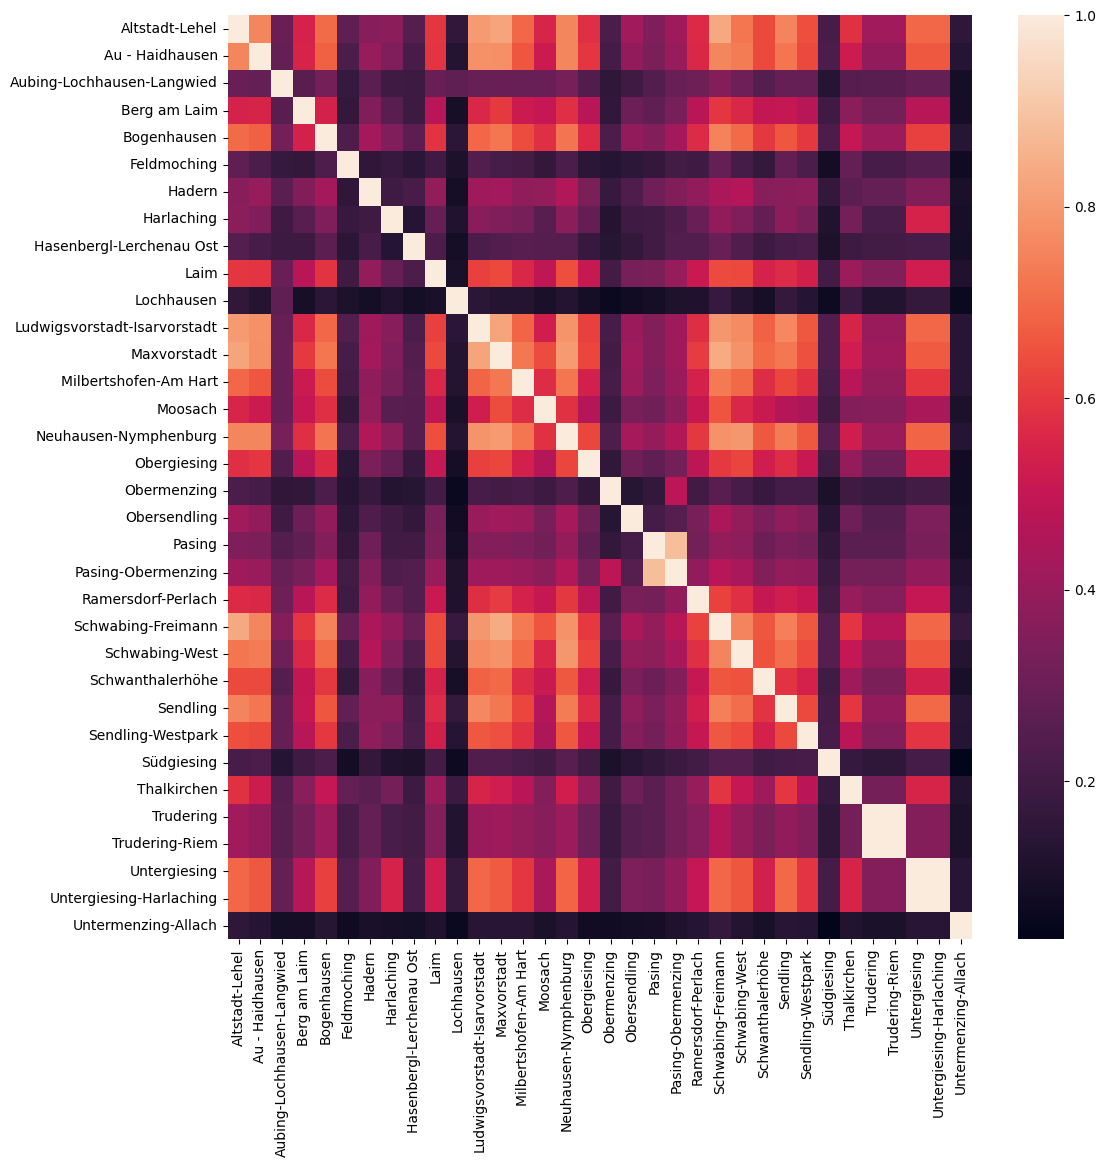

In [25]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(data.drop(columns='rental_date_hour').corr(), ax=ax);

In [26]:
# var(x-y)/var(x)
data.describe()

,rental_date_hour,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
count,34632,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,...,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000
mean,2021-01-01 00:15:55.509355520,6.716967,3.516314,0.286556,1.191961,2.383085,0.056422,0.598319,0.219364,0.111920,...,2.018220,3.181566,1.570542,0.124942,0.619918,0.330446,0.330446,1.842804,1.842804,0.019577
min,2019-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019-12-30 21:45:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2020-12-29 02:30:00,4.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,2022-01-02 23:15:00,9.000000,5.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,5.000000,2.000000,0.000000,1.000000,0.000000,0.000000,3.000000,3.000000,0.000000
max,2022-12-31 23:00:00,75.000000,35.000000,11.000000,14.000000,39.000000,7.000000,15.000000,8.000000,9.000000,...,23.000000,38.000000,19.000000,6.000000,26.000000,13.000000,13.000000,24.000000,24.000000,6.000000
std,NaN,8.620787,3.974017,0.730027,1.615558,3.025092,0.295097,1.094285,0.576570,0.394374,...,2.462033,3.999474,2.114272,0.392546,1.291125,0.770781,0.770781,2.511722,2.511722,0.157835


In [33]:
variances = data.describe().loc['std'][1:]**2

In [35]:
variances

Altstadt-Lehel                   74.317973
Au - Haidhausen                  15.792809
Aubing-Lochhausen-Langwied        0.532939
Berg am Laim                      2.610027
Bogenhausen                       9.151183
Feldmoching                       0.087082
Hadern                             1.19746
Harlaching                        0.332433
Hasenbergl-Lerchenau Ost          0.155531
Laim                              4.014479
Lochhausen                        0.019301
Ludwigsvorstadt-Isarvorstadt     58.687723
Maxvorstadt                     125.511553
Milbertshofen-Am Hart            24.883998
Moosach                            8.15596
Neuhausen-Nymphenburg            44.607526
Obergiesing                       3.897112
Obermenzing                       0.102758
Obersendling                      0.668245
Pasing                            0.607561
Pasing-Obermenzing                1.029365
Ramersdorf-Perlach                2.842998
Schwabing-Freimann               76.949678
Schwabing-W

In [46]:
var_dict = {x_key: [np.var(data[x_key]-data[y_key])/x_val for y_key, y_val in variances.items()] for x_key, x_val in variances.items()}
var_dict

{'Altstadt-Lehel': [0.0,
  0.5137512338944357,
  0.9568651026807313,
  0.8301223576232772,
  0.6327573860534105,
  0.9823572104926415,
  0.9231509497437954,
  0.9549688684216173,
  0.9795319763601952,
  0.7770724970419722,
  0.9950699060881866,
  0.3639109741474609,
  0.5448699260713235,
  0.531736973685647,
  0.7423333369887011,
  0.42730058428504575,
  0.7866004967212178,
  0.9845099253322723,
  0.9287419341013431,
  0.9456687864270847,
  0.9152077765342574,
  0.8179162540852132,
  0.3369287931142086,
  0.4816873497695849,
  0.719749164780041,
  0.5182830638323436,
  0.7437498373938792,
  0.9822691487010181,
  0.8475560438415113,
  0.9323477538058105,
  0.9323477538058105,
  0.6815211795526026,
  0.6815211795526026,
  0.9946423610397146],
 'Au - Haidhausen': [2.4176160916294718,
  0.0,
  0.9286722333688252,
  0.7200351162898136,
  0.5466690164728955,
  0.9717914561247567,
  0.8566351691041336,
  0.9206006342508861,
  0.9668972146215864,
  0.6599841210505518,
  0.9921873457644677,
  1

In [53]:
pd.DataFrame(var_dict, index=data.columns[1:])

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
Altstadt-Lehel,0.000000,2.417616,133.434101,23.636925,5.138707,838.364208,57.293548,213.490549,468.053031,14.385543,...,8.824442,2.407992,12.365137,473.743275,37.785563,116.629953,116.629953,8.028420,8.028420,2967.239785
Au - Haidhausen,0.513751,0.000000,27.519727,4.356805,0.943423,176.238955,11.297814,43.734710,98.179834,2.596353,...,1.569832,0.552641,2.150958,98.850272,7.275702,23.601712,23.601712,1.406550,1.406550,628.261576
Aubing-Lochhausen-Langwied,0.956865,0.928672,0.000000,0.973157,0.901555,6.270836,1.094778,2.107966,3.724560,0.916022,...,0.940511,0.928039,0.919475,3.965958,1.034897,1.410417,1.410417,0.919600,0.919600,21.616324
Berg am Laim,0.830122,0.720035,4.765958,0.000000,0.705640,29.181857,2.143029,7.425369,16.203559,0.885998,...,0.778846,0.757010,0.866283,16.346102,1.640318,4.054432,4.054432,0.810794,0.810794,103.963732
Bogenhausen,0.632757,0.546669,15.480746,2.474088,0.000000,101.320884,6.299904,24.901242,55.741309,1.504437,...,1.040271,0.576581,1.331160,56.838856,4.140978,13.183641,13.183641,0.964900,0.964900,363.215587
Feldmoching,0.982357,0.971791,1.024656,0.973640,0.964167,0.000000,0.988396,1.082751,1.342157,0.963980,...,0.974309,0.964563,0.956740,1.441087,0.922551,0.980585,0.980585,0.955416,0.955416,4.217885
Hadern,0.923151,0.856635,2.459852,0.983205,0.824361,13.591312,0.000000,3.865131,7.491818,0.871620,...,0.872880,0.873508,0.874189,7.848820,1.275589,2.202187,2.202187,0.884305,0.884305,47.662935
Harlaching,0.954969,0.920601,1.314892,0.945752,0.904583,4.133351,1.073020,0.000000,2.759417,0.916588,...,0.923007,0.912506,0.892583,2.810674,0.913321,1.226814,1.226814,0.802630,0.802630,13.659412
Hasenbergl-Lerchenau Ost,0.979532,0.966897,1.086963,0.965568,0.947365,2.397122,0.973069,1.291012,0.000000,0.949359,...,0.964975,0.967615,0.950123,1.789389,0.975614,1.048954,1.048954,0.957312,0.957312,6.816203
Laim,0.777072,0.659984,6.900134,1.362751,0.659973,44.439226,2.922102,11.068762,24.504302,0.000000,...,0.771790,0.681822,0.888092,24.953240,2.136477,5.929529,5.929529,0.795445,0.795445,159.242666


In [54]:
stds = data.describe().loc['std'][1:]

In [57]:
std_dict = {x_key: [np.std(data[x_key]-data[y_key])/x_val for y_key, y_val in variances.items()] for x_key, x_val in stds.items()}

In [60]:
pd.DataFrame(std_dict, index=data.columns[1:])

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
Altstadt-Lehel,0.000000,1.554869,11.551368,4.861782,2.266872,28.954520,7.569250,14.611316,21.634533,3.792828,...,2.970596,1.551771,3.516410,21.765644,6.146996,10.799535,10.799535,2.833447,2.833447,54.472376
Au - Haidhausen,0.716764,0.000000,5.245925,2.087296,0.971300,13.275502,3.361222,6.613222,9.908574,1.611320,...,1.252929,0.743398,1.466615,9.942347,2.697351,4.858159,4.858159,1.185981,1.185981,25.065147
Aubing-Lochhausen-Langwied,0.978195,0.963676,0.000000,0.986487,0.949503,2.504164,1.046316,1.451883,1.929912,0.957091,...,0.969800,0.963348,0.958892,1.991471,1.017299,1.187610,1.187610,0.958958,0.958958,4.649336
Berg am Laim,0.911111,0.848549,2.183107,0.000000,0.840024,5.402023,1.463909,2.724953,4.025364,0.941274,...,0.882522,0.870063,0.930743,4.043031,1.280749,2.013562,2.013562,0.900441,0.900441,10.196261
Bogenhausen,0.795460,0.739371,3.934558,1.572923,0.000000,10.065828,2.509961,4.990114,7.466010,1.226555,...,1.019937,0.759329,1.153759,7.539155,2.034939,3.630928,3.630928,0.982293,0.982293,19.058216
Feldmoching,0.991139,0.985795,1.012253,0.986732,0.981920,0.000000,0.994181,1.040553,1.158515,0.981825,...,0.987071,0.982122,0.978131,1.200453,0.960495,0.990245,0.990245,0.977454,0.977454,2.053749
Hadern,0.960807,0.925546,1.568392,0.991567,0.907943,3.686640,0.000000,1.965994,2.737119,0.933606,...,0.934280,0.934616,0.934981,2.801575,1.129420,1.483977,1.483977,0.940375,0.940375,6.903835
Harlaching,0.977225,0.959479,1.146688,0.972498,0.951095,2.033064,1.035867,0.000000,1.661149,0.957386,...,0.960733,0.955252,0.944766,1.676506,0.955678,1.107616,1.107616,0.895896,0.895896,3.695864
Hasenbergl-Lerchenau Ost,0.989713,0.983309,1.042575,0.982633,0.973327,1.548264,0.986443,1.136227,0.000000,0.974351,...,0.982331,0.983674,0.974743,1.337680,0.987732,1.024184,1.024184,0.978423,0.978423,2.610786
Laim,0.881517,0.812394,2.626811,1.167369,0.812387,6.666275,1.709416,3.326975,4.950182,0.000000,...,0.878516,0.825725,0.942386,4.995322,1.461669,2.435063,2.435063,0.891877,0.891877,12.619139


In [ ]:
# for each district 
    # calculate distance to all the other districts
        # take average

In [61]:
data.drop(columns=['rental_date_hour','Maxvorstadt'])-data['Maxvorstadt']

: 

: 

In [6]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
drop_cols=['rental_date_hour']
cols = set(data.columns)-set(drop_cols)
X = data.drop(columns=drop_cols)
data_scaled = pd.DataFrame(std_scaler.fit_transform(X), columns=list(cols))
data_scaled = pd.concat([data_scaled, data[drop_cols]], axis=1)
data_scaled.head()

,Pasing-Obermenzing,Untermenzing-Allach,Obermenzing,Obergiesing,Schwabing-West,Ramersdorf-Perlach,Laim,Schwanthalerhöhe,Moosach,Ludwigsvorstadt-Isarvorstadt,...,Lochhausen,Sendling,Trudering,Harlaching,Obersendling,Au - Haidhausen,Aubing-Lochhausen-Langwied,Schwabing-Freimann,Maxvorstadt,rental_date_hour
0,-0.663170,-0.884839,-0.392533,-0.737812,-0.787784,-0.1912,-0.546775,-0.380468,-0.283794,-0.791618,...,-0.795508,0.203126,-0.318291,-0.480145,-0.428722,-0.428722,-0.733692,-0.733692,-0.124038,2019-01-01 00:00:00
1,-0.779171,-0.884839,-0.392533,-0.737812,-0.126638,-0.1912,-0.546775,-0.380468,-0.283794,-0.791618,...,-0.295435,-0.742839,-0.318291,-0.480145,-0.428722,-0.428722,-0.335553,-0.335553,-0.124038,2019-01-01 01:00:00
2,-0.663170,-0.633201,-0.392533,-0.737812,-0.126638,-0.1912,-0.546775,-0.380468,-0.283794,0.705696,...,0.454675,-0.742839,-0.318291,-0.480145,-0.428722,-0.428722,-0.335553,-0.335553,-0.124038,2019-01-01 02:00:00
3,-0.779171,0.121714,-0.392533,-0.737812,-0.787784,-0.1912,-0.546775,-0.380468,-0.283794,0.206591,...,-0.795508,-0.742839,-0.318291,-0.480145,-0.428722,-0.428722,-0.335553,-0.335553,-0.124038,2019-01-01 03:00:00
4,-0.547170,-0.633201,-0.392533,-0.737812,-0.787784,-0.1912,-0.546775,-0.380468,-0.283794,-0.292514,...,-0.795508,-0.269856,-0.318291,-0.480145,-0.428722,-0.428722,-0.733692,-0.733692,-0.124038,2019-01-01 04:00:00


In [7]:
kstest(rvs=data_scaled['Maxvorstadt'], cdf=data_scaled['Altstadt-Lehel'])

KstestResult(statistic=0.9356953106953106, pvalue=0.0, statistic_location=-0.23906818386368048, statistic_sign=-1)

In [22]:
kstest_dict = {x_col: [kstest(rvs=data_scaled[x_col], cdf=data_scaled[y_col]).pvalue for y_col in data_scaled.columns[:-1]] for x_col in data_scaled.columns[:-1]}

<Axes: >

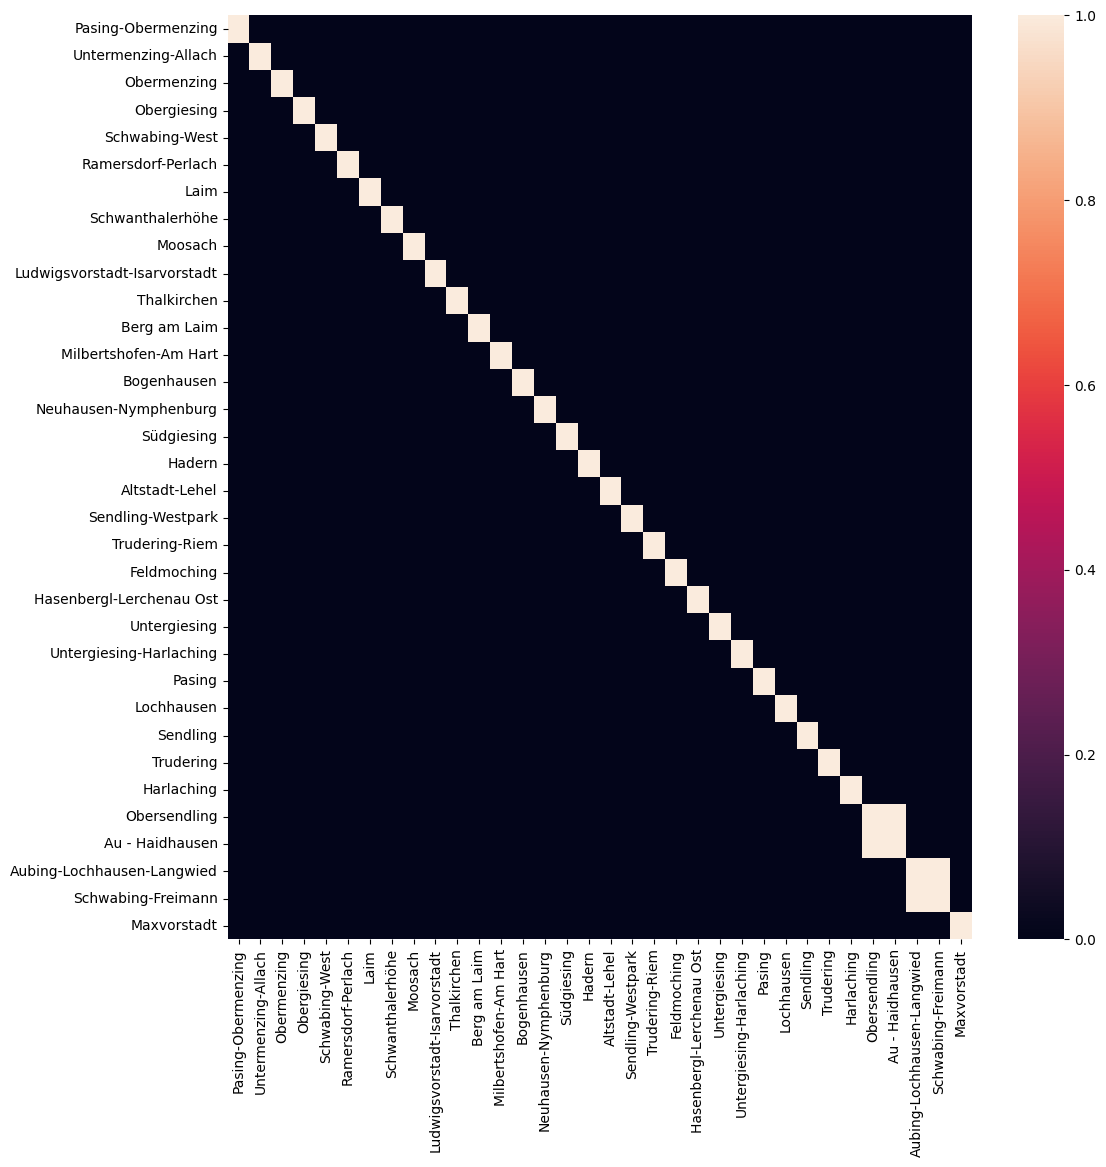

In [27]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(pd.DataFrame(kstest_dict, index=data_scaled.columns[:-1]), ax=ax)